In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 840 files belonging to 3 classes.
Using 672 files for training.
Using 168 files for validation.


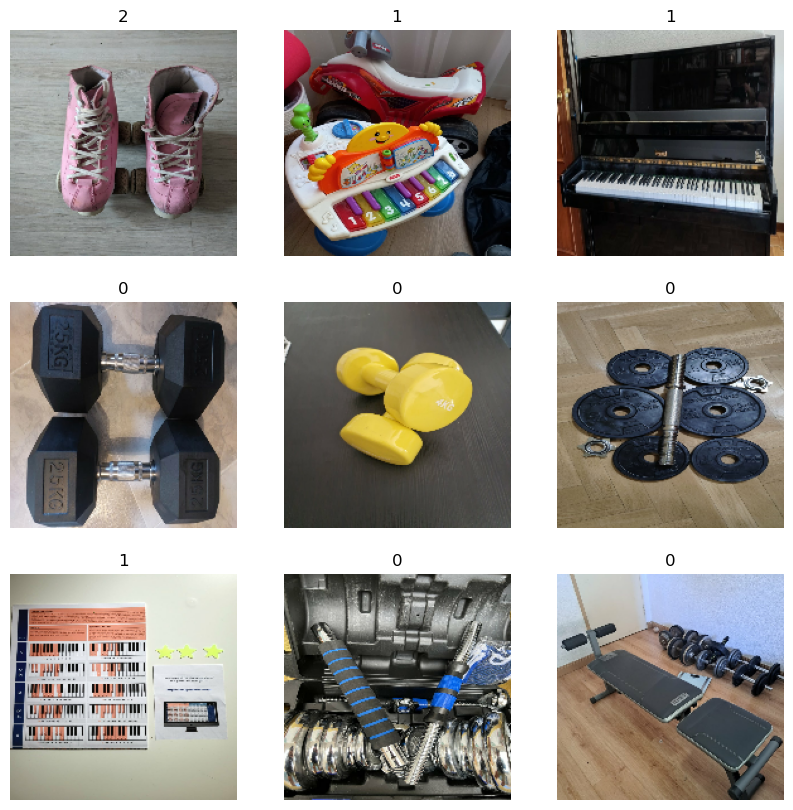

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

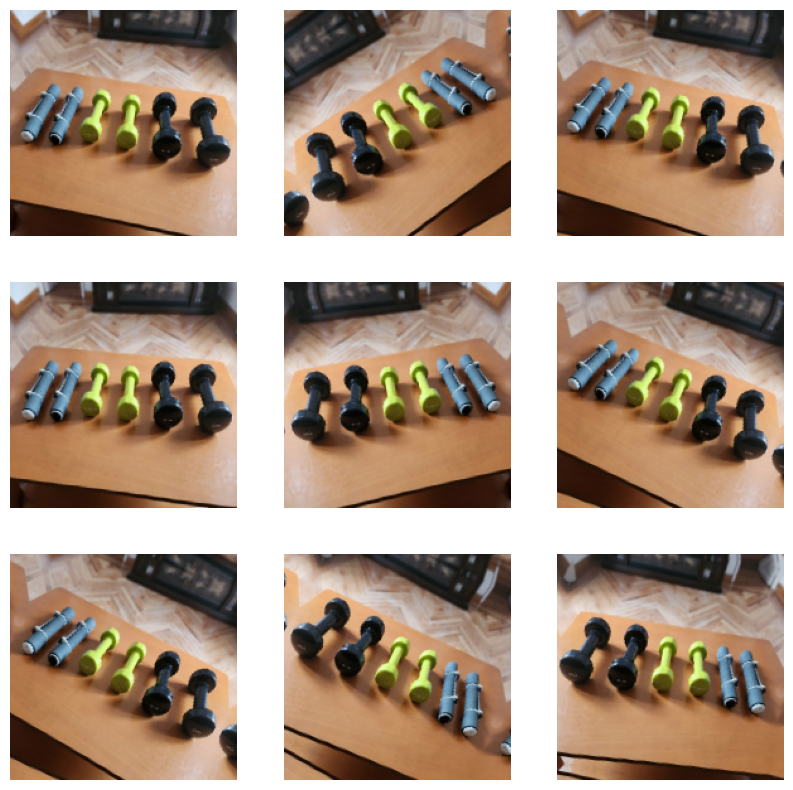

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [31]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [32]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


En cmd hemos instalado graphviz usando:
winget install graphviz


In [33]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
epochs = 7

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/7
6/6 [==============================] - 147s 22s/step - loss: 0.2269 - accuracy: 0.3676 - val_loss: 0.6201 - val_accuracy: 0.3274
Epoch 2/7
6/6 [==============================] - 137s 22s/step - loss: -0.0816 - accuracy: 0.3452 - val_loss: 0.5304 - val_accuracy: 0.3274
Epoch 3/7
6/6 [==============================] - 143s 23s/step - loss: -0.5760 - accuracy: 0.3512 - val_loss: 0.4576 - val_accuracy: 0.3274
Epoch 4/7
6/6 [==============================] - 137s 22s/step - loss: -1.1379 - accuracy: 0.3765 - val_loss: 0.3691 - val_accuracy: 0.3274
Epoch 5/7
6/6 [==============================] - 136s 22s/step - loss: -1.4565 - accuracy: 0.3839 - val_loss: 0.2831 - val_accuracy: 0.3274
Epoch 6/7
6/6 [==============================] - 152s 25s/step - loss: -2.2108 - accuracy: 0.3824 - val_loss: 0.2317 - val_accuracy: 0.3274
Epoch 7/7
6/6 [==============================] - 149s 24s/step - loss: -2.6709 - accuracy: 0.4077 - val_loss: 0.1304 - val_accuracy: 0.3274


In [35]:
img = keras.preprocessing.image.load_img(
    "images\mancuernas\mancuernas_9.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 1s 826ms/step
This image is 22.02% cat and 77.98% dog.
